In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()

sns.set_style("ticks")

In [59]:
hydra_table = pd.read_csv("Fields-DR3/hydra_probgal0.7.csv", usecols=['RA', 'DEC', 'zml', 'r_petro', 'g_petro',
                                                                          'odds', 'PROB_GAL'])

In [60]:
ra = hydra_table["RA"]
dec = hydra_table["DEC"]
zml = hydra_table["zml"]
rpetro = hydra_table["r_petro"]
gpetro = hydra_table["g_petro"]
odds = hydra_table["odds"]
prob_gal = hydra_table["PROB_GAL"]

In [116]:
#Defining the center of Hydra (in degress) --> from NED 
ra_0 = 159.17
dec_0 = -27.524

#radius of Hydra
radius = 1.5744

#calculating distances
def dist(ra, dec):
    return np.sqrt((ra - ra_0)**2 + (dec - dec_0)**2)


mask = (zml > 0.0) & (zml < 0.1) & (rpetro < 19) & (odds > 0.7) & (prob_gal > 0.8)

#From the color_distribution, we conclude that a good division between red and blue galaxies is at g-r = 0.7

color_cut = 0.7
mask_red = (gpetro - rpetro) > color_cut
mask_blue = (gpetro - rpetro)< color_cut

distance = dist(ra[mask], dec[mask])
distance_red = distance[mask_red]
distance_blue = distance[mask_blue]

In [117]:
def numb_galaxies(distance):
    
    dr = radius / 10
    numb_galaxies = [] 
    area = []
    radii = np.arange(dr, 5*radius, dr)

    for r in radii:
        cond = (distance > r) & (distance < (r + dr))

        numb_galaxies.append(np.sum(cond))
        area.append(np.pi*(r*dr + r**2))
    
    sigma = np.array(numb_galaxies)/np.array(area)  
    error = np.sqrt(np.array(numb_galaxies))/np.array(area)
    
    return sigma, error


sigma, error = numb_galaxies(distance)
sigma_red, error_red = numb_galaxies(distance_red)
sigma_blue, error_blue = numb_galaxies(distance_blue)

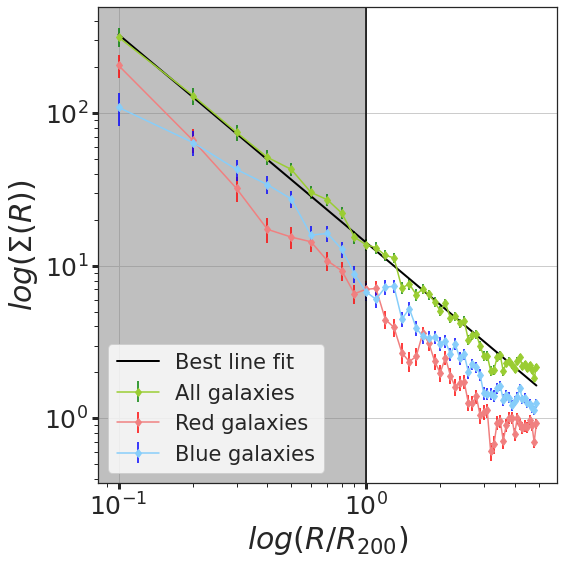

In [158]:
fontsize = 30
labelsize = 25

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.errorbar(x=radii/radius, y=sigma, color='yellowgreen', yerr=error, 
                fmt='d-', ecolor='green', label="All galaxies")
ax.errorbar(x=radii/radius, y=sigma_red, color='lightcoral', yerr=error_red, 
                fmt='d-', ecolor='red', label="Red galaxies")
ax.errorbar(x=radii/radius, y=sigma_blue, color='lightskyblue', yerr=error_blue, 
                fmt='d-', ecolor='blue', label="Blue galaxies")

x = np.log10(radii/radius)
ax.plot(10**x, 10**function(x, a, b), '-', color="black", linewidth=2.0, label="Best line fit")

ax.axvspan(0, 1, alpha=0.5, color='grey')
ax.axvline(x=1, color='black')
ax.set_xlabel(r"$log(R/R_{200})$", fontsize=fontsize)
ax.set_ylabel(r"$log(\Sigma(R))$", fontsize=fontsize)
ax.grid()

ax.yaxis.set_tick_params(labelsize=labelsize, width=3)
ax.xaxis.set_tick_params(labelsize=labelsize, width=3)

ax.set_yscale('log')
ax.set_xscale('log')

plt.legend(fontsize=fontsize*0.7)

fig.tight_layout()
plt.savefig("../Presentations/cosmo22-splus-poster/radial_distribution-ylog-xlog-0.7-curvefit.png", format='png')

In [149]:
x.max()

4.8999999999999995

## Slope fit

Slope of the curve = -1.361


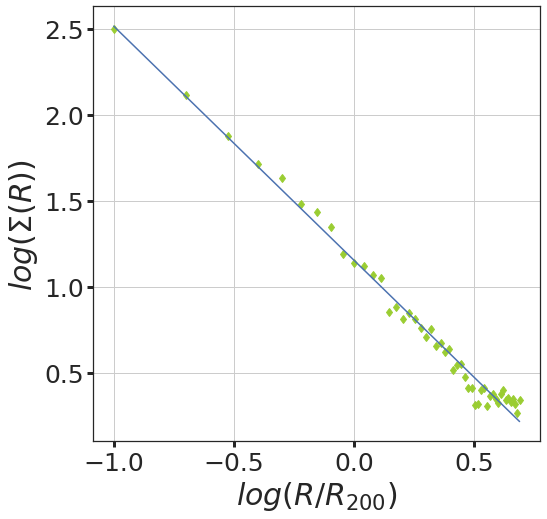

In [142]:
from scipy.optimize import curve_fit

def function(x, a, b):
   return a*x + b


x = np.log10(radii/radius)
y = np.log10(sigma)

popt,cov = curve_fit(function, x, y)
a,b = popt


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.plot(x, y, 'd', color='yellowgreen')
ax.plot(x, function(x, a, b), '-')
ax.set_xlabel(r"$log(R/R_{200})$", fontsize=fontsize)
ax.set_ylabel(r"$log(\Sigma(R))$", fontsize=fontsize)
ax.yaxis.set_tick_params(labelsize=labelsize, width=3)
ax.xaxis.set_tick_params(labelsize=labelsize, width=3)
ax.grid()

print("Slope of the curve = {:.3f}".format(a))